# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
# Unity
from unityagents import UnityEnvironment

# pre-made
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import time
import random
import torch

# tennis environment, 2 players
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
print(brain)

Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
# set training parameters
SOLVED = 0.5
EPISODES = 100
PRINT_EVERY = 10
NOISE = True

In [14]:
# Agent
from Agent import Agent

In [15]:
# train function
# 4000 episodes as default

def train(n_episodes=4000, max_t=1000, train_mode=True):
    '''Training function for multiple agents, actor-critic logic.'''
    
    scores_window = deque(maxlen=EPISODES)
    scores_all = []
    moving_average = []
    best_score = -np.inf
    best_episode = 0
    already_solved = False    

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset environment
        states = np.reshape(env_info.vector_observations, (1,48)) # combine agent states
        agent_0.reset() # reset agent0
        agent_1.reset() # reset agent1
        scores = np.zeros(num_agents)
        while True:
            actions = concat_actions(states, NOISE)            # combine both actions
            env_info = env.step(actions)[brain_name]           # both actions send to the environment
            next_states = np.reshape(env_info.vector_observations, (1, 48)) # combine next states
            rewards = env_info.rewards                         
            done = env_info.local_done                        
            agent_0.step(states, actions, rewards[0], next_states, done, 0) # agent 1 learns
            agent_1.step(states, actions, rewards[1], next_states, done, 1) # agent 2 learns
            scores += np.max(rewards)                          
            states = next_states                              
            if np.any(done):                                   
                break

        ep_best_score = np.max(scores)
        scores_window.append(ep_best_score)
        scores_all.append(ep_best_score)
        moving_average.append(np.mean(scores_window))

        # save best score                        
        if ep_best_score > best_score:
            best_score = ep_best_score
            best_episode = i_episode
        
        # print results
        if i_episode % PRINT_EVERY == 0:
            print('Episodes {:0>4d}-{:0>4d}\tMax reward: {:.3f}\Average reward: {:.3f}'.format(
                i_episode-PRINT_EVERY, i_episode, np.max(scores_all[-PRINT_EVERY:]), moving_average[-1]))

        # check if environment is solved
        if moving_average[-1] >= SOLVED:
            if not already_solved:
                print('<-- Environment SOLVED in {:d} episodes! \
                \n<-- Average: {:.3f} over past {:d} episodes'.format(
                    i_episode-EPISODES, moving_average[-1], EPISODES))
                already_solved = True
                # save weights
                torch.save(agent_0.actor_local.state_dict(), 'models/checkpoint_actor_0.pth')
                torch.save(agent_0.critic_local.state_dict(), 'models/checkpoint_critic_0.pth')
                torch.save(agent_1.actor_local.state_dict(), 'models/checkpoint_actor_1.pth')
                torch.save(agent_1.critic_local.state_dict(), 'models/checkpoint_critic_1.pth')
            elif ep_best_score >= best_score:
                print('<-- Best episode so far!\
                \nEpisode {:0>4d}\tMax Reward: {:.3f}\tAverage: {:.3f}'.format(
                i_episode, ep_best_score, moving_average[-1]))
                # save weights
                torch.save(agent_0.actor_local.state_dict(), 'models/checkpoint_actor_0.pth')
                torch.save(agent_0.critic_local.state_dict(), 'models/checkpoint_critic_0.pth')
                torch.save(agent_1.actor_local.state_dict(), 'models/checkpoint_actor_1.pth')
                torch.save(agent_1.critic_local.state_dict(), 'models/checkpoint_critic_1.pth')
            elif (i_episode-best_episode) >= 200:
                # stop training if model is no longer improving
                print('<-- Model is no longer improving.')
                break
            else:
                continue
            
    return scores_all, moving_average

In [16]:
# get the actions for both agents
def concat_actions(states, add_noise):
    action_0 = agent_0.act(states, add_noise)
    action_1 = agent_1.act(states, add_noise)
    return np.concatenate((action_0, action_1), axis = 0).flatten()

In [17]:
# initialize agents with Agent class
agent_0 = Agent(state_size, action_size, num_agents = 1, random_seed = 123)
agent_1 = Agent(state_size, action_size, num_agents = 1, random_seed = 123)

In [18]:
# run the training and see the scores
scores, averages = train()

Episodes 0000-0010	Max reward: 0.000\Average reward: 0.000
Episodes 0010-0020	Max reward: 0.000\Average reward: 0.000
Episodes 0020-0030	Max reward: 0.000\Average reward: 0.000
Episodes 0030-0040	Max reward: 0.000\Average reward: 0.000
Episodes 0040-0050	Max reward: 0.000\Average reward: 0.000
Episodes 0050-0060	Max reward: 0.100\Average reward: 0.003
Episodes 0060-0070	Max reward: 0.100\Average reward: 0.004
Episodes 0070-0080	Max reward: 0.000\Average reward: 0.004
Episodes 0080-0090	Max reward: 0.100\Average reward: 0.004
Episodes 0090-0100	Max reward: 0.000\Average reward: 0.004
Episodes 0100-0110	Max reward: 0.100\Average reward: 0.006
Episodes 0110-0120	Max reward: 0.100\Average reward: 0.008
Episodes 0120-0130	Max reward: 0.100\Average reward: 0.011
Episodes 0130-0140	Max reward: 0.000\Average reward: 0.011
Episodes 0140-0150	Max reward: 0.000\Average reward: 0.011
Episodes 0150-0160	Max reward: 0.000\Average reward: 0.009
Episodes 0160-0170	Max reward: 0.100\Average reward: 0.0

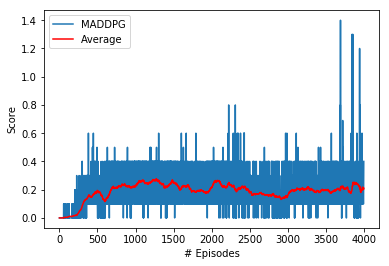

In [19]:
# plot the results 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='MADDPG')
plt.plot(np.arange(len(scores)), averages, c='r', label='Average')
plt.ylabel('Score')
plt.xlabel('# Episodes')
plt.legend(loc='upper left');
plt.show()